In [121]:
import ast
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [122]:
train_data = pd.read_csv("./test_data.csv")
test_data = pd.read_csv("./test_data.csv")

# convert `text` column back to list
train_data["text"] = train_data["text"].apply(ast.literal_eval)
test_data["text"] = test_data["text"].apply(ast.literal_eval)

### 1. Naive Bayes - based only on the content of the articles

In [123]:
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(train_data["text"].apply(lambda words: " ".join(words)))
y = train_data["label"]

In [124]:
NB_classifier = MultinomialNB()
NB_classifier.fit(X, y)

pass

In [125]:
X_test = vectorizer.transform(test_data["text"].apply(lambda words: " ".join(words)))
y_pred = NB_classifier.predict(X_test)

accuracy = accuracy_score(test_data["label"], y_pred)

accuracy

0.9035385361124576

In [126]:
print(classification_report(test_data["label"], y_pred))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      2037
           1       0.96      0.85      0.90      2089

    accuracy                           0.90      4126
   macro avg       0.91      0.90      0.90      4126
weighted avg       0.91      0.90      0.90      4126



### 2. Logistic Regression - based on author

In [127]:
onehot = OneHotEncoder()

X = onehot.fit_transform(np.array(train_data["author"]).reshape(-1, 1))
y = train_data["label"]

LR = LogisticRegression()

LR.fit(X, y)

pass

In [128]:
X_test = onehot.transform(np.array(test_data["author"]).reshape(-1, 1))
y_pred = LR.predict(X_test)

accuracy = accuracy_score(test_data["label"], y_pred)

accuracy

0.8691226369365003

In [129]:
print(classification_report(test_data["label"], y_pred))

              precision    recall  f1-score   support

           0       0.88      0.85      0.87      2037
           1       0.86      0.89      0.87      2089

    accuracy                           0.87      4126
   macro avg       0.87      0.87      0.87      4126
weighted avg       0.87      0.87      0.87      4126



### 3. Custom Neural Network - based on both conent and author

In [130]:
vocab_file = open("./data/text_vocab.json", mode="r")
text_vocab = json.load(vocab_file)


vocab_size

140914

In [158]:
def padding_post(sequence, length):
    return np.array(sequence + [0] * (length - len(sequence)))

In [132]:
def encode_text(sequence):
    return [text_vocab[word] for word in sequence]

In [133]:
def get_data(df, batch_size, max_len):
    for i in range(0, len(df["text"]), batch_size):
        x = [encode_text(padding_post(sequence, max_len)) for sequence in df["text"].iloc[i:i+batch_size]]
        y = [label for label in df["label"].iloc[i:i+batch_size]]

        yield x, y

In [171]:
vocab_size = len(text_vocab)
embedding_dim = 2
max_len = max(train_data['text'].str.len())
drop_value = 0.3
batch_size = 32
epoch=10

In [ ]:
# creating dense vectors from the input sequences
Training_seq = [encode_text(sequence) for sequence in train_data["text"]]
Training_pad = np.array([padding_post(sequence, max_len) for sequence in Training_seq])

Test_seq = [encode_text(sequence) for sequence in test_data["text"]]
Test_pad = np.array([padding_post(sequence, max_len) for sequence in Test_seq])

In [176]:
model = tf.keras.models.Sequential([tf.keras.layers.Embedding(vocab_size, 16, input_length=max_len),
                                  tf.keras.layers.GlobalAveragePooling1D(),
                                  tf.keras.layers.Dropout(0.5),
                                  tf.keras.layers.Dense(16,activation='relu'),
                                  tf.keras.layers.Dropout(0.5),
                                  tf.keras.layers.Dense(1,activation='sigmoid')])


model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),metrics=['accuracy'],optimizer='adam')

early_stop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

history = model.fit(Training_pad, train_data["label"], epochs=epoch, callbacks=[early_stop], verbose=2)


Epoch 1/10
129/129 - 4s - loss: 0.6580 - accuracy: 0.6927 - 4s/epoch - 34ms/step
Epoch 2/10
129/129 - 4s - loss: 0.4845 - accuracy: 0.8548 - 4s/epoch - 27ms/step
Epoch 3/10
129/129 - 4s - loss: 0.2984 - accuracy: 0.9164 - 4s/epoch - 28ms/step
Epoch 4/10
129/129 - 4s - loss: 0.2002 - accuracy: 0.9423 - 4s/epoch - 29ms/step
Epoch 5/10
129/129 - 4s - loss: 0.1480 - accuracy: 0.9549 - 4s/epoch - 28ms/step
Epoch 6/10
129/129 - 4s - loss: 0.1183 - accuracy: 0.9627 - 4s/epoch - 28ms/step
Epoch 7/10
129/129 - 4s - loss: 0.0923 - accuracy: 0.9704 - 4s/epoch - 28ms/step
Epoch 8/10
129/129 - 4s - loss: 0.0760 - accuracy: 0.9794 - 4s/epoch - 27ms/step
Epoch 9/10
129/129 - 4s - loss: 0.0635 - accuracy: 0.9823 - 4s/epoch - 28ms/step
Epoch 10/10
129/129 - 3s - loss: 0.0585 - accuracy: 0.9859 - 3s/epoch - 27ms/step


In [177]:
model.evaluate(Test_pad, test_data["label"])

129/129 [==============================] - 0s 2ms/step - loss: 0.0242 - accuracy: 0.9976


[0.024190040305256844, 0.9975763559341431]

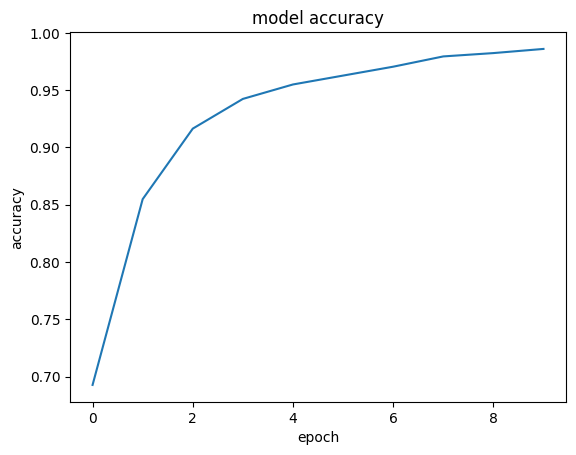

In [178]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.show()

In [175]:
# Define the model architecture
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model.add(LSTM(128))
model.add(Dropout(drop_value))
model.add(Dense(32, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

# Train the model
model.fit(
    Training_pad,
    tf.convert_to_tensor(train_data['label']),
    epochs=10, batch_size=32, callbacks=[early_stop]
)

# Evaluate the model
loss, accuracy = model.evaluate(Test_pad, test_data['label'])
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

model compiled
start training
Epoch 1/10
129/129 [==============================] - 79s 596ms/step - loss: 0.6937 - accuracy: 0.4968
Epoch 2/10
129/129 [==============================] - 76s 586ms/step - loss: 0.6932 - accuracy: 0.5080
Epoch 3/10
129/129 [==============================] - 81s 631ms/step - loss: 0.6934 - accuracy: 0.5007
Epoch 4/10
129/129 [==============================] - 84s 654ms/step - loss: 0.6934 - accuracy: 0.4966
Epoch 5/10
129/129 [==============================] - 76s 588ms/step - loss: 0.6932 - accuracy: 0.5097
Epoch 6/10
129/129 [==============================] - 76s 586ms/step - loss: 0.6931 - accuracy: 0.5034
Epoch 7/10
129/129 [==============================] - 76s 590ms/step - loss: 0.6935 - accuracy: 0.4978
Epoch 8/10
129/129 [==============================] - 78s 606ms/step - loss: 0.6930 - accuracy: 0.5032
Epoch 9/10
129/129 [==============================] - 79s 612ms/step - loss: 0.6935 - accuracy: 0.5056
Epoch 10/10
129/129 [======================